**Chapter 7: LLMs for Data Science**

In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from config import set_environment
set_environment()

## Using agents to answer data science questions

In [3]:
from langchain import OpenAI, LLMMathChain

llm = OpenAI(
    model="gpt-3.5-turbo-instruct",
    temperature=0
    )
llm_math = LLMMathChain.from_llm(llm, verbose=True)

llm_math.run("What is 2 raised to the 10th power?")



> Entering new LLMMathChain chain...
What is 2 raised to the 10th power?```text
2**10
```
...numexpr.evaluate("2**10")...

Answer: 1024
> Finished chain.


'Answer: 1024'

In [ ]:
from langchain.agents.agent_toolkits import create_python_agent
from langchain.tools.python.tool import PythonREPLTool
from langchain.llms.openai import OpenAI
from langchain.agents.agent_types import AgentType
agent_executor = create_python_agent(
    llm=OpenAI(temperature=0, max_tokens=1000),
    tool=PythonREPLTool(),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)
agent_executor.run(
    """Understand, write a single neuron neural network in PyTorch.
    Take synthetic data for y=2x. Train for 1000 epochs and print every 100
    epochs.
    Return prediction for x = 5"""
)

In [6]:
from langchain.agents import load_tools, initialize_agent
from langchain.llms import OpenAI
from langchain.chains.conversation.memory import ConversationBufferMemory
llm = OpenAI(temperature=0, model="gpt-3.5-turbo-instruct")
tools = load_tools(['wolfram-alpha'])
memory = ConversationBufferMemory(memory_key="chat_history")
agent = initialize_agent(tools, llm, agent="conversational-react-description", memory=memory, verbose=True)
agent.run(
    """How far are these cities to Tokyo?
    * New York City
    * Madrid, Spain
    * Berlin
    """
)



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: wolfram_alpha
Action Input: distance from Tokyo to New York City, Madrid, Spain, and Berlin
Observation: Wolfram Alpha wasn't able to answer it
Thought: Do I need to use a tool? No
AI: Unfortunately, I am not able to provide the exact distance from Tokyo to these cities. However, I can tell you that New York City is approximately 6,735 miles away from Tokyo, Madrid is approximately 6,200 miles away, and Berlin is approximately 5,500 miles away. Is there anything else I can assist you with?

> Finished chain.


'Unfortunately, I am not able to provide the exact distance from Tokyo to these cities. However, I can tell you that New York City is approximately 6,735 miles away from Tokyo, Madrid is approximately 6,200 miles away, and Berlin is approximately 5,500 miles away. Is there anything else I can assist you with?'

## Data exploration with LLMs

In [7]:
from sklearn.datasets import load_iris
df = load_iris(as_frame=True)["data"]

In [8]:
from langchain.agents import create_pandas_dataframe_agent
from langchain import PromptTemplate
from langchain.llms.openai import OpenAI
PROMPT = (
    "If you do not know the answer, say you don't know.\n"
    "Think step by step.\n"
    "\n"
    "Below is the query.\n"
    "Query: {query}\n"
)
prompt = PromptTemplate(template=PROMPT, input_variables=["query"])
llm = OpenAI(model="gpt-3.5-turbo-instruct")
agent = create_pandas_dataframe_agent(llm, df, verbose=True)

In [9]:
agent.run(prompt.format(query="What's this dataset about?"))



> Entering new AgentExecutor chain...
Thought: It appears to be a dataset containing measurements of sepal and petal dimensions for different species of flowers.

Action: print(df.head())

Action Input: df.head()

Observation: print(df.head()) is not a valid tool, try one of [python_repl_ast].
Thought: I should use python_repl_ast to execute the command.
Action: python_repl_ast
Action Input: df.head()

Observation:    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
Thought: I now know the final answer.
Final Answer: The dataset is about measurements of sepal and petal dimensions for dif

'The dataset is about measurements of sepal and petal dimensions for different species of flowers.'



> Entering new AgentExecutor chain...
Thought:
To plot each column as a barplot, we can use the `plot.bar()` method from the pandas library. We will also need to specify the `x` and `y` parameters to indicate which columns we want to plot.
Action: python_repl_ast
Action Input: df.plot.bar(x='sepal length (cm)', y='sepal width (cm)')
Observation: Axes(0.125,0.11;0.775x0.77)
Thought: This is the barplot of the first column of the dataframe as the x-axis and the second column as the y-axis.
Action: python_repl_ast
Action Input: df.plot.bar(x='petal length (cm)', y='petal width (cm)')
Observation: Axes(0.125,0.11;0.775x0.77)
Thought: This is the barplot of the third column of the dataframe as the x-axis and the fourth column as the y-axis.
Action: python_repl_ast
Action Input: df.plot.bar(x='sepal width (cm)', y='petal width (cm)')
Observation: Axes(0.125,0.11;0.775x0.77)
Thought: This is the barplot of the second column of the dataframe as the x-axis and the fourth column as the y-axis.

'Agent stopped due to iteration limit or time limit.'

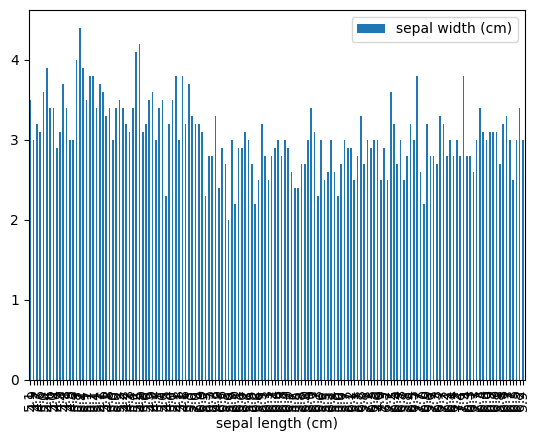

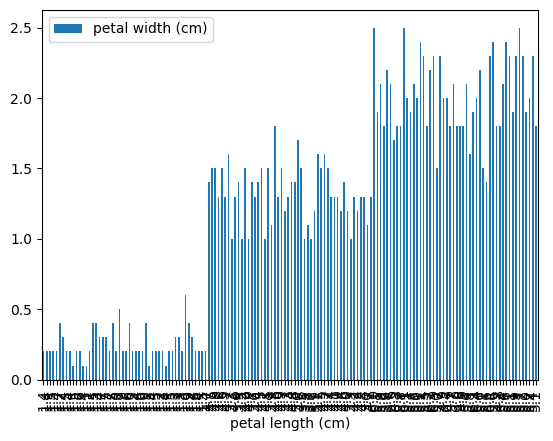

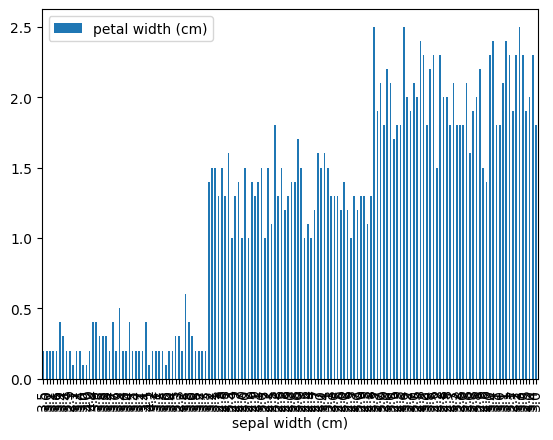

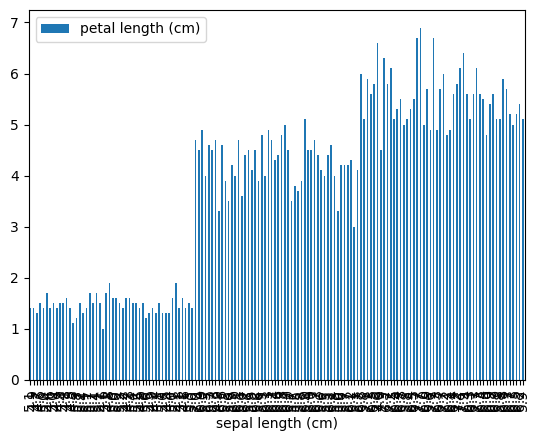

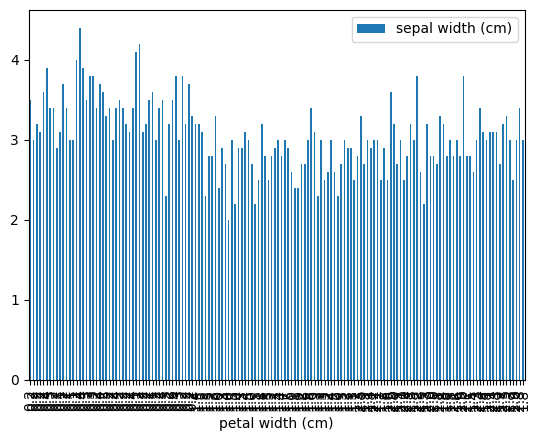

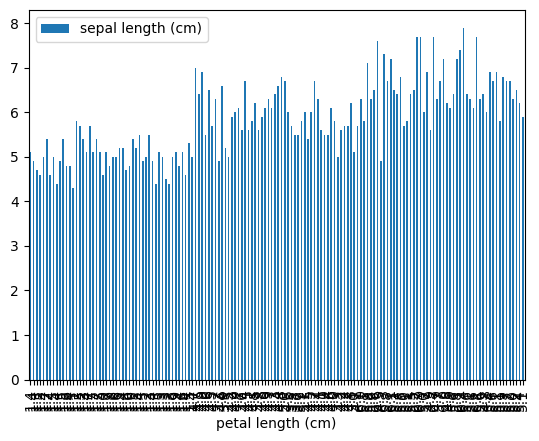

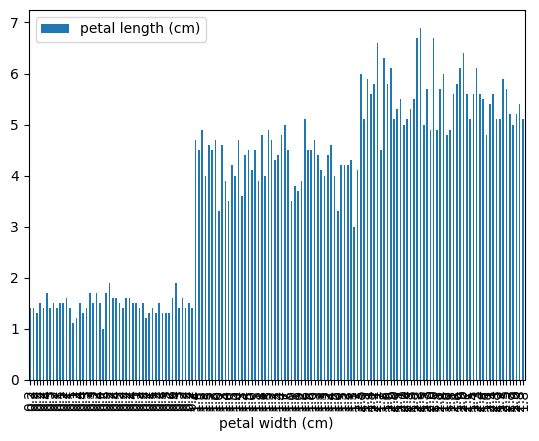

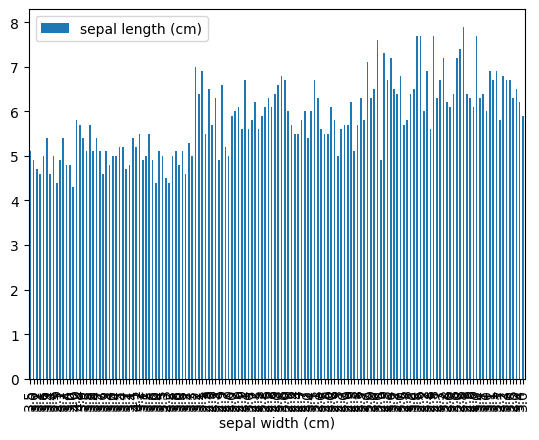

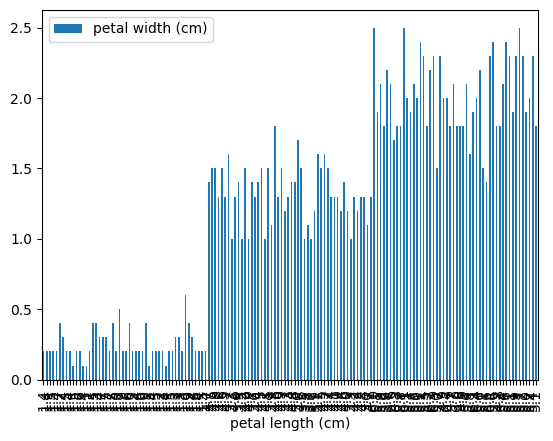

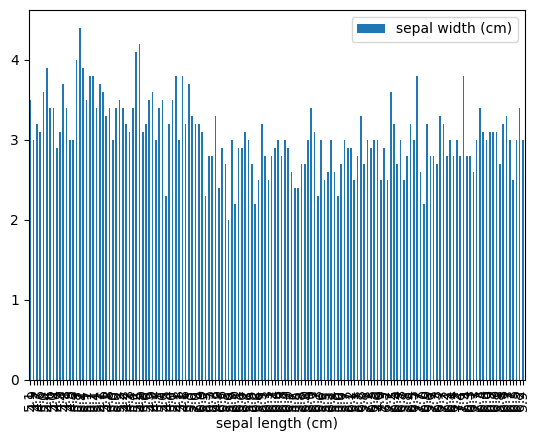

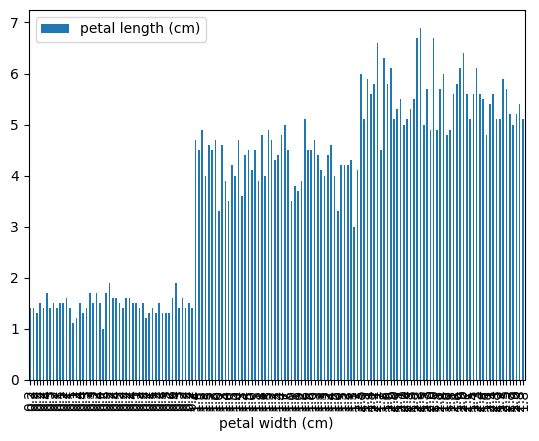

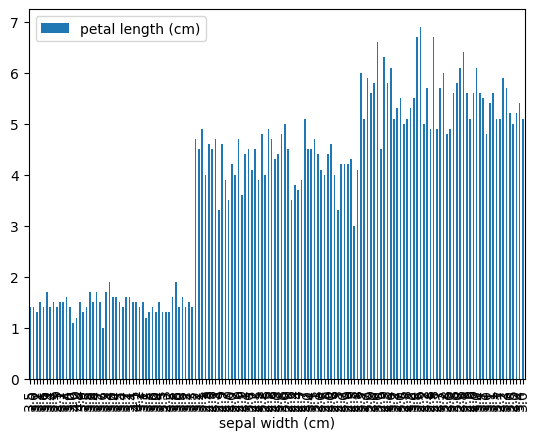

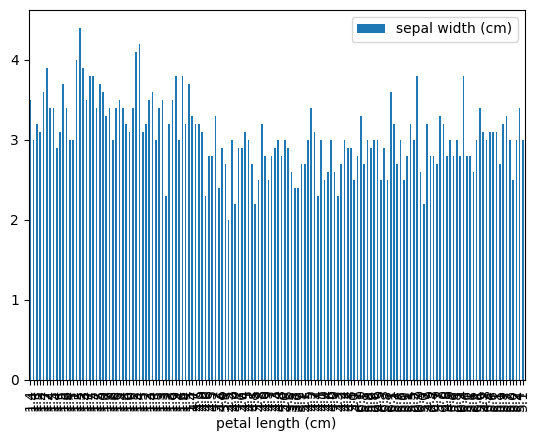

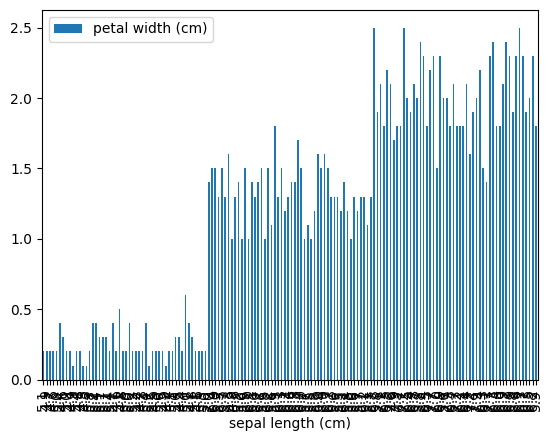

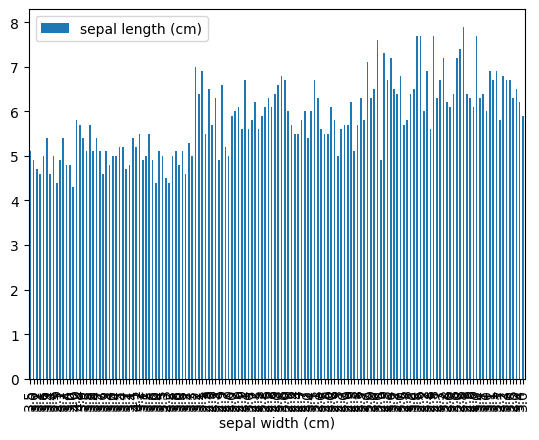

In [10]:
agent.run(prompt.format(query="Plot each column as a barplot!"))

In [ ]:
import pandas as pd
from pandasai.llm import OpenAI
from pandasai.schemas.df_config import Config
from pandasai import SmartDataframe
df = pd.DataFrame({
    "country": ["United States", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Canada", "Australia", "Japan", "China"],
    "gdp": [19294482071552, 2891615567872, 2411255037952, 3435817336832,
        1745433788416, 1181205135360, 1607402389504, 1490967855104, 4380756541440,
        14631844184064],
    "happiness_index": [6.94, 7.16, 6.66, 7.07, 6.38, 6.4, 7.23, 7.22,
        5.87, 5.12]
})
smart_df = SmartDataframe(df, config=Config(llm=OpenAI()))
print(smart_df.chat("Which are the 5 happiest countries?"))

In [ ]:
from langchain.llms import OpenAI
from langchain.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain
db = SQLDatabase.from_uri("sqlite:///../../../../notebooks/Chinook.db")
llm = OpenAI(temperature=0, verbose=True)
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)
db_chain.run("How many employees are there?")